In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt


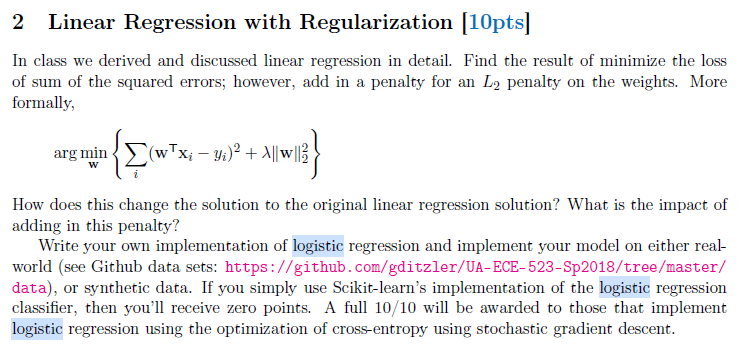

In [3]:
def split_dataset(dataset,train_percent):
    """
    Input: Dataset : dataframe  train_percent: percentage (0.0 - 1.0)
    Output: 4x dataframes: x-testing,x-training,y-testing,y-training
    """
    #dataset = shuffle_dataset(dataset)
    y = dataset.iloc[:,-1]
    x = dataset.iloc[:, 0:-1]
    test_size = int(train_percent * y.size)
    #create testing
    yts = y.iloc[:test_size,].reset_index(drop=True)
    xts = x.iloc[:test_size,].reset_index(drop=True)
    #create training
    ytr = y.iloc[test_size:,].reset_index(drop=True)
    xtr = x.iloc[test_size:,].reset_index(drop=True)
    return xts,xtr,yts,ytr

def shuffle_dataset(xt,yt):
    """
    Shuffles the data collectively
    Input:    xt : feature data    yt : class data
    Output:   Separate feature and class vector in appropriate order
    """
    xy = pd.concat([xt, yt], axis=1)
    xy2 = xy.sample(frac=1).reset_index(drop=True)
    y = xy2.iloc[:,-1]
    x = xy2.iloc[:, 0:-1]
    return x,y

def logistic_function(x,w):
    """
    Logistic Function 1/(1+exp(-wTx))
    """
    wTx = np.dot(x, w)
    temp = 1 / (1 + np.exp(-wTx))
    return temp

def cross_entropy(x, y, w):
    """
    Cross Entropy: log loss measure the converges  
    Only works with binary class at the moment
    """
    temp = - np.sum (y * np.log(logistic_function(x,w)) + (1-y)* np.log(1- logistic_function(x,w)))
    return temp

def gradient(x, y, w, eta):
    """
    Gradient f(x)f()
    """
    temp = np.dot(x.T, logistic_function(x,w) - y)
    return eta * temp


def sgd(xtr,ytr, T,eta):
    """
    SGD: Logistic Regression using Stochastic Gradiant Descent 
    Input: xtr:training feature data, ytr:training class data
            T: iterations, eta: learning rate 
    Output:  wnew: parameter vector, k: occurences cross enthropy worked
    """
    wnew = np.zeros((xtr.shape[1],1))     #initialize parameter vector w(4x1)
    n = len(ytr.iloc[:,]) # size of the training dataset
    ce = 1 #initialize cross enthropy val
    k = 0

    for i in range(T):
        xtr,ytr = shuffle_dataset(xtr,ytr) #shuffle data each iteration
        for j in range(n):
            wold = wnew
            x_i = np.array([xtr.iloc[j]]) #set xtrain row to nparray
            y_i = np.array(ytr.iloc[j]) # set ytrain nparray
            wnew = wold - gradient(x_i,y_i,wold,eta) #get updated  parameters
            temp_ce = cross_entropy(x_i, y_i, wnew) #perform cross etrophy 
            ce_dif = abs(temp_ce - ce) #compare previous ce with new ce
            if (ce_dif < 0.00001):  #break if minimum is found less then 0.00001
                ce = 1  
                k=k+1           #count occurences of ce
                break
            else:
                ce = temp_ce    #progress ce 
    return wnew,k

In [14]:

!ls

gdrive	sample_data


In [18]:
path = "/content/gdrive/MyDrive/Git/ECE523/HW2/acute_inflamation.csv"
dataset = pd.read_csv(path, header=None)  

#split dataset into testing and traing
xtest,xtrain,ytest,ytrain = split_dataset(dataset,.6)

#train w parameters 
wtr,k = sgd(xtrain,ytrain,1000,0.02)

#test w parameters against xtest feature data 
yhat = logistic_function(xtest,wtr)
for i in range(len(yhat)):
    if yhat[i] >=0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0


print("w parameters: \n", wtr)
print("k occurences using Cross Entropy: ",k)
dif_y = yhat[:,0] - ytest[:]
perc_correct = (1.0 - (float(np.count_nonzero(dif_y))/len(dif_y)))*100

print("Precent Accuracy with test data: ", perc_correct)

print("\nModify ytest[2] value (1 out of %s) to confirm SGD working..." % ytest.size)
if ytest[2]==1:
    ytest[2]=0
else:
    ytest[2]=1

dif_y = yhat[:,0] - ytest[:]
perc_correct = (1.0 - (float(np.count_nonzero(dif_y))/len(dif_y)))*100

print("Precent Accuracy with altered test data: ", perc_correct)
print(ytest.size)

w parameters: 
 [[-2.78368288]
 [ 1.99715886]
 [-2.0301456 ]
 [ 5.46981692]
 [ 3.22064441]
 [-0.13217954]]
k occurences using Cross Entropy:  610
Precent Accuracy with test data:  100.0

Modify ytest[2] value (1 out of 72) to confirm SGD working...
Precent Accuracy with altered test data:  98.61111111111111
72


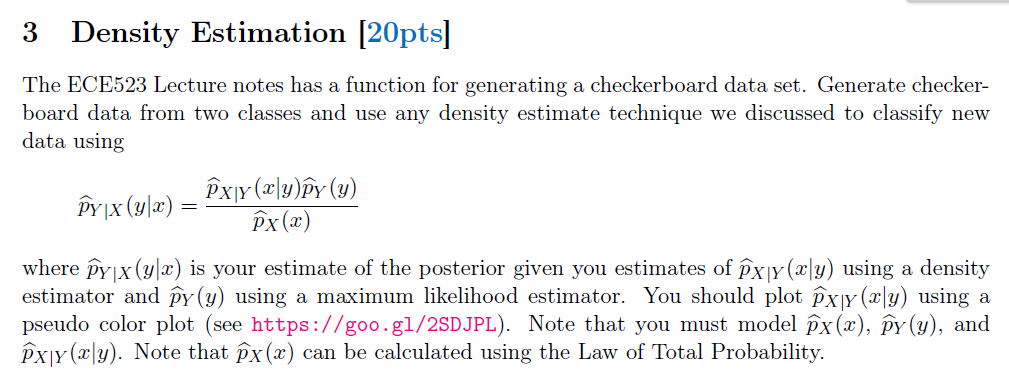

In [ ]:

def gen_checkerboard(N,a,alpha):
    """
    N: number of point on board
    a: width of the board
    alpha: rotation of the checkerboard (radians)
    """
    d = np.random.rand(N,2).T
    d_transformed = np.array([d[0]*np.cos(alpha)-d[1]*np.sin(alpha),
                            d[0]*np.sin(alpha)+d[1]*np.cos(alpha)]).T
    s = np.ceil(d_transformed[:,0]/a)+np.floor(d_transformed[:,1]/a)
    
    lab = 2 - (s%2)
    data = d.T
    return data, lab

def algorithm_k_NN(k,point,dataset):
    """
    k = k number of point to compare to 
    xt_point = test data point
    x = x1,x2 feature data
    y = classifiers
    """
    #Add distance from test point to training points in datasets to datasets
    dataset['distance'] = np.sqrt((dataset['x1'] - point[0]) ** 2 +
                                         (dataset['x2'] - point[1]) ** 2)

    #Sort Distances in Dataset in ascending order
    dataset.sort_values(by=['distance'],inplace=True)
    
    #create a set of closest K distances
    k_set = dataset.iloc[:k]
    k_list = k_set['y1'].to_numpy()

    #Take largest distance for kmax and set to radius
    radius = k_set['distance'].max()

    #len of training data
    y1_len = len(dataset.y1)

    #Total Count of training where y == 1,2
    n1 = (dataset.y1.values == 1).sum()
    n2 = (dataset.y1.values == 2).sum()
    
    #Count when K == 1,2
    k1,k2 = 0 ,0
    if (1.0 in k_list) == True:
        k1 = k_set['y1'].value_counts()[1]
    if (2.0 in k_list) == True:
        k2 = k_set['y1'].value_counts()[2]

    #calculate volume
    volume = np.pi * (radius**2)
    #p(x|y=1)
    pxy1 = k1/(n1*volume)
    #p(x|y=2)
    pxy2 = k2/(n2*volume)
    #p(y=1)  NOTE: n1 equals total 1's in y1
    py1  = n1/y1_len
    #p(y=2)  NOTE: n2 equals total 2's in y1
    py2  = n2/y1_len
    
    #p(x) both equate
    pxtot = ((pxy1*py1)+(pxy2*py2))
    px = k/((n1+n2)*volume)    
    #p(y=1|x)
    py1x = (pxy1*py1)/px
    #p(y=2|x)
    py2x = (pxy2*py2)/px
    #compare and output
    if py1x > py2x:
        return 1, py1x, py2x
    else:
        return 2, py1x, py2x

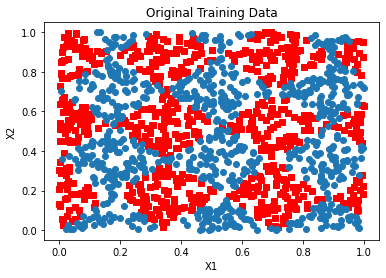

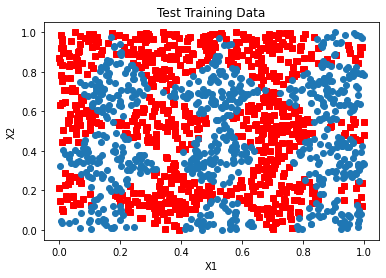

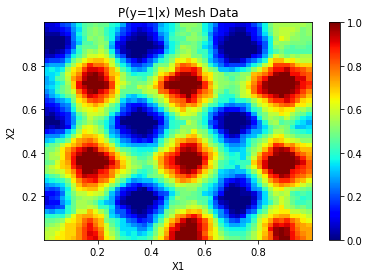

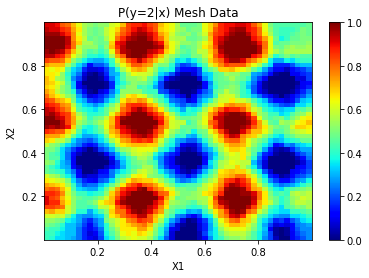

In [ ]:
N=1500
x,y = gen_checkerboard(N,.25,3.14159/4)
xtest,yt = gen_checkerboard(N,.25,3.14159/4)
k = int(np.sqrt(N))

#organize training dataset
dataset = pd.DataFrame(x,columns=['x1','x2'])
dataset['y1'] = y

#Create y test output set
ytest = np.zeros(len(yt))
#Go through each test point and run Knn
i=0
for xp in xtest:
    ytest[i],pnan,qnan = algorithm_k_NN(k,xp,dataset) 
    i+=1 

# Using the bounds of the test feature vector,
# generate 50x50 set for each possible point
xmin, xmax = np.min(xtest[:,0]),np.max(xtest[:,0])
ymin, ymax = np.min(xtest[:,1]),np.max(xtest[:,1])
xm, ym = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]

#Generate empty posterior sets same shape as xm,ym (50x50)
pxy1 = np.zeros(xm.shape)
pxy2 = np.zeros(xm.shape)

#Iterate through each point on grid, and collect the posterior for 1 or 2 
for i in range(len(xm[0])):
    for j in range(len(xm[1])):
        ynan, pxy1[i,j],pxy2[i,j] = algorithm_k_NN(k,[xm[i,j],ym[i,j]],dataset)

#Plot
plt.figure()
plt.plot(x[np.where(y==2)[0],0],x[np.where(y==2)[0],1],'s',c = 'r')
plt.plot(x[np.where(y==1)[0],0],x[np.where(y==1)[0],1],'o')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title('Original Training Data')
plt.show()
plt.plot(xtest[np.where(ytest==2)[0],0],xtest[np.where(ytest==2)[0],1],'s',c = 'r')
plt.plot(xtest[np.where(ytest==1)[0],0],xtest[np.where(ytest==1)[0],1],'o')
plt.title('Test Training Data')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

#Plot posterior probabilities for each point in grids
plt.figure()
plt.pcolormesh(xm,ym,pxy1,cmap='jet')
plt.colorbar()
plt.title('P(y=1|x) Mesh Data')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

plt.figure()
plt.pcolormesh(xm,ym,pxy2,cmap='jet')
plt.colorbar()
plt.title('P(y=2|x) Mesh Data')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
